## Desafio Árvore de Decisão

### Imports

In [1]:
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import optuna

In [2]:
# Lendo dataset
df_transacoes = pd.read_csv('./data/transacoes_fraude.csv')

### EDA

In [3]:
df_transacoes.describe()

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Classe
count,13000.000000,13000.000000,13000.000000,13000.000000
mean,2511.899952,7547.003386,5035.103435,0.110000
std,1436.446865,3225.212074,2884.967560,0.312902
min,10.000000,95.440000,10.120000,0.000000
25%,1279.412500,5038.805000,2533.727500,0.000000
50%,2525.610000,7538.255000,4997.090000,0.000000
75%,3754.945000,10046.875000,7551.552500,0.000000
max,4999.960000,14897.740000,9999.390000,1.000000


In [4]:
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cliente                     13000 non-null  object 
 1   Tipo de Transacao           13000 non-null  object 
 2   Valor da Transacao          13000 non-null  float64
 3   Valor Anterior a Transacao  13000 non-null  float64
 4   Valor Apos a Transacao      13000 non-null  float64
 5   Horario da Transacao        13000 non-null  object 
 6   Classe                      13000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 711.1+ KB


In [5]:
df_transacoes.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0


In [6]:
df_transacoes['Classe'].unique()

array([0, 1])

In [7]:
df_transacoes['Tipo de Transacao'].unique()

array(['Saque', 'PIX', 'Débito', 'Crédito'], dtype=object)

In [8]:
contagem_target = df_transacoes.value_counts('Classe')
contagem_target

Classe
0    11570
1     1430
Name: count, dtype: int64

Percebe-se que os dados estão desbalanceados, há mais casos com transações legítmas do que fraudulentas

In [9]:
px.bar(contagem_target,color=contagem_target.index)

In [10]:
percentual_target = (contagem_target/len(df_transacoes)) * 100
px.bar(percentual_target,color=percentual_target.index)

In [11]:
contadem_tipo_transacao = df_transacoes.value_counts('Tipo de Transacao')
contadem_tipo_transacao

Tipo de Transacao
Débito     3290
PIX        3274
Saque      3244
Crédito    3192
Name: count, dtype: int64

In [12]:
px.bar(contadem_tipo_transacao,color=contadem_tipo_transacao.index)

In [13]:
percentual_tipo_transacao = (contadem_tipo_transacao/len(df_transacoes)) * 100
px.bar(percentual_tipo_transacao, color=percentual_tipo_transacao.index)

In [16]:
crosstab_transacoes = pd.crosstab(df_transacoes['Tipo de Transacao'], 
                                  df_transacoes['Classe'])
tabela_formatada = ff.create_table(crosstab_transacoes.reset_index())
tabela_formatada.show()

In [ ]:
px.histogram(df_transacoes,x='Valor da Transacao')

In [21]:
px.histogram(df_transacoes,x='Valor Anterior a Transacao')

In [23]:
px.histogram(df_transacoes,x='Valor Apos a Transacao')

In [26]:
px.box(df_transacoes, x='Classe',y='Valor da Transacao', color='Classe')

In [28]:
px.box(df_transacoes, x='Tipo de Transacao',y='Valor da Transacao', color='Tipo de Transacao')

In [56]:
df_transacoes['Horario da Transacao'] = pd.to_datetime(df_transacoes['Horario da Transacao'])
df_transacoes['Hora'] = df_transacoes['Horario da Transacao'].dt.hour
df_transacoes['Dia_da_Semana'] = df_transacoes['Horario da Transacao'].dt.dayofweek
df_transacoes.head()

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,Dia_da_Semana
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14 07:29:28.256579,0,7,1
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12 17:54:09.119410,0,17,6
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03 17:31:42.087599,0,17,1
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23 17:57:02.055680,0,17,3
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07 17:30:36.879557,0,17,4


In [60]:
contagem_horas = df_transacoes.value_counts('Hora')
contagem_horas

Hora
3     625
1     608
4     607
23    604
2     592
5     570
0     561
9     543
22    542
8     535
11    534
7     533
17    532
19    525
12    524
13    516
14    514
20    511
6     510
16    510
10    507
21    503
15    497
18    497
Name: count, dtype: int64

In [61]:
px.bar(contagem_horas,color=contagem_horas.index)

In [62]:
contagem_dias = df_transacoes.value_counts('Dia_da_Semana')
contagem_dias

Dia_da_Semana
0    1879
6    1878
2    1861
1    1854
3    1854
4    1841
5    1833
Name: count, dtype: int64

In [63]:
px.bar(contagem_dias,color=contagem_dias.index)

In [64]:
crosstab_hora = pd.crosstab(df_transacoes['Classe'],df_transacoes['Hora'])
tabela = ff.create_table(crosstab_hora.reset_index())
tabela.show()

In [66]:
crosstab_dia = pd.crosstab(df_transacoes['Classe'], df_transacoes['Dia_da_Semana'])
tabela_dia = ff.create_table(crosstab_dia.reset_index())
tabela_dia.show()

In [71]:
# Teste de Qui-Quadrado de Pearson
# H0 - as variáveis são independentes
# H1 - as variáveis não são independentes

valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_transacoes,'Classe','Hora')

In [72]:
valor_esperado

Hora,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Classe,,,,,,,,,,,,,,,,,,,,,
0,499.29,541.12,526.88,556.25,540.23,507.3,453.9,474.37,476.15,483.27,...,457.46,442.33,453.9,473.48,442.33,467.25,454.79,447.67,482.38,537.56
1,61.71,66.88,65.12,68.75,66.77,62.7,56.1,58.63,58.85,59.73,...,56.54,54.67,56.1,58.52,54.67,57.75,56.21,55.33,59.62,66.44


In [73]:
valor_observado

Hora,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Classe,,,,,,,,,,,,,,,,,,,,,
0,461,493,478,512,499,513,464,494,496,507,...,475,463,466,489,451,484,466,454,497,498
1,100,115,114,113,108,57,46,39,39,36,...,39,34,44,43,46,41,45,49,45,106


In [74]:
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,276.00896,23.0,0.0,0.14571,1.0
1,cressie-read,0.66667,268.34141,23.0,0.0,0.14367,1.0
2,log-likelihood,0.00000,256.22416,23.0,0.0,0.14039,1.0
3,freeman-tukey,-0.50000,249.67280,23.0,0.0,0.13858,1.0
4,mod-log-likelihood,-1.00000,245.09082,23.0,0.0,0.13731,1.0
5,neyman,-2.00000,241.34939,23.0,0.0,0.13625,1.0


As variáveis Classe e tipo de transação são dependentes Qui-Quadrado (p-value = 0.03450)

As variáveis Classe e Valor da transação são independentes Qui-Quadrado (p-value = 0.54523)

As variáveis Classe e Valor Apos a Transacao são independentes Qui-Quadrado (p-value = 0.3975)

As variáveis Classe e Horário da Transacao são independentes Qui-Quadrado (p-value = 0.49588)

As variáveis Classe e Dia_da_Semana são independentes Qui-Quadrado (p-value = 0.47714)

As variáveis Classe e Hora são dependentes Qui-Quadrado (p-value = 0.0)


### Treinamento do Modelo

In [75]:
X = df_transacoes.drop(columns=['Classe', 'Cliente', 'Horario da Transacao'])
y = df_transacoes['Classe']

In [78]:
categorial_features = ['Tipo de Transacao']

categorical_transformer = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("oneHot",OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat",categorical_transformer,categorial_features)
    ]
)

dt_cls = Pipeline(
    steps=[
        ("preprecessing",preprocess),
        ("classifier", DecisionTreeClassifier())
    ]
)

In [80]:
# Validação Cruzada
cv_folds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
metrics_result = cross_validate(dt_cls,X,y,cv=cv_folds,scoring=['accuracy'], return_estimator=True)

In [81]:
metrics_result

{'fit_time': array([0.00799012, 0.00471306, 0.0045054 ]),
 'score_time': array([0.00253272, 0.00230622, 0.00224996]),
 'estimator': [Pipeline(steps=[('preprecessing',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('oneHot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['Tipo de Transacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprecessing',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleI

In [82]:
metrics_result['test_accuracy'].mean()

np.float64(0.8900000046150297)

### Métricas

In [83]:
y_pred = cross_val_predict(dt_cls,X,y,cv=cv_folds)

In [84]:
classification_report_str = classification_report(y,y_pred)
print(f'Relatório:\n {classification_report_str}')

Relatório:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     11570
           1       0.00      0.00      0.00      1430

    accuracy                           0.89     13000
   macro avg       0.45      0.50      0.47     13000
weighted avg       0.79      0.89      0.84     13000



/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/orlando/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



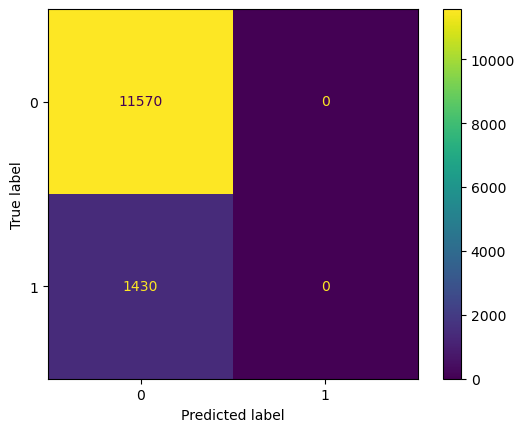

In [85]:
confusion_matrix_model = confusion_matrix(y,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix_model)
disp.plot()

In [90]:
def decision_tree_optuna(trial):
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_depth = trial.suggest_int('max_depth', 2, 100)

    dt_cls.set_params(classifier__min_samples_leaf = min_samples_leaf)
    dt_cls.set_params(classifier__max_depth = max_depth)

    scores = cross_val_score(dt_cls,X,y,cv=cv_folds,scoring='accuracy')
    return scores.mean()

In [91]:
estudo_decisiontreee = optuna.create_study(direction='maximize')
estudo_decisiontreee.optimize(decision_tree_optuna,n_trials=500)

[I 2025-10-10 16:16:14,729] A new study created in memory with name: no-name-15b9ffe2-cb61-4814-bc87-a25ab3393179
[I 2025-10-10 16:16:14,761] Trial 0 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 33, 'max_depth': 65}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-10-10 16:16:14,785] Trial 1 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 4, 'max_depth': 92}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-10-10 16:16:14,809] Trial 2 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 20, 'max_depth': 69}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-10-10 16:16:14,832] Trial 3 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 7, 'max_depth': 63}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-10-10 16:16:14,855] Trial 4 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 11, 'max_depth': 21}. Best is trial 0 with 

In [92]:
print(f'Melhor Acurácia: {estudo_decisiontreee.best_value}')
print(f'Melhores Parâmetros: {estudo_decisiontreee.best_params}')

Melhor Acurácia: 0.8900000046150297
Melhores Parâmetros: {'min_samples_leaf': 33, 'max_depth': 65}


In [93]:
X_train_tree = X.copy()
X_train_tree['Tipo_de_Transacao_label'] = X_train_tree['Tipo de Transacao'].astype('category').cat.codes
X_train_tree.drop(columns=['Tipo de Transacao'],axis=1, inplace=True)
X_train_tree.rename(columns={'Tipo_de_Transacao_label': 'Tipo de Transacao'}, inplace=True)
X_train_tree.head()

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Hora,Dia_da_Semana,Tipo de Transacao
0,390.39,5446.75,5056.36,7,1,3
1,3272.03,12167.89,8895.86,17,6,3
2,4905.72,8217.63,3311.91,17,1,2
3,3073.23,7833.16,4759.93,17,3,2
4,4233.03,6920.82,2687.79,17,4,2


In [94]:
clf_decision_tree = DecisionTreeClassifier(min_samples_leaf=estudo_decisiontreee.best_params['min_samples_leaf'],
                                           max_depth=estudo_decisiontreee.best_params['max_depth'])
y_train_tree = y.copy()

clf_decision_tree.fit(X_train_tree,y_train_tree)

,criterion,'gini'
,splitter,'best'
,max_depth,65
,min_samples_split,2
,min_samples_leaf,33
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.47405906850511603, 0.9814814814814815, 'Hora <= 4.5\ngini = 0.196\nsamples = 13000\nvalue = [11570, 1430]'),
 Text(0.17934240079860245, 0.9444444444444444, 'Valor Anterior a Transacao <= 8480.365\ngini = 0.3\nsamples = 2993\nvalue = [2443, 550]'),
 Text(0.3267007346518592, 0.962962962962963, 'True  '),
 Text(0.12259795358123285, 0.9074074074074074, 'Valor Apos a Transacao <= 7194.175\ngini = 0.279\nsamples = 1788\nvalue = [1488, 300]'),
 Text(0.11860494135263289, 0.8703703703703703, 'Valor Anterior a Transacao <= 1494.08\ngini = 0.287\nsamples = 1730\nvalue = [1430, 300]'),
 Text(0.11461192912403294, 0.8333333333333334, 'gini = 0.123\nsamples = 61\nvalue = [57, 4]'),
 Text(0.12259795358123285, 0.8333333333333334, 'Valor Anterior a Transacao <= 1859.89\ngini = 0.292\nsamples = 1669\nvalue = [1373, 296]'),
 Text(0.11860494135263289, 0.7962962962962963, 'gini = 0.444\nsamples = 33\nvalue = [22, 11]'),
 Text(0.12659096580983278, 0.7962962962962963, 'Valor Anterior a Transacao <= 70

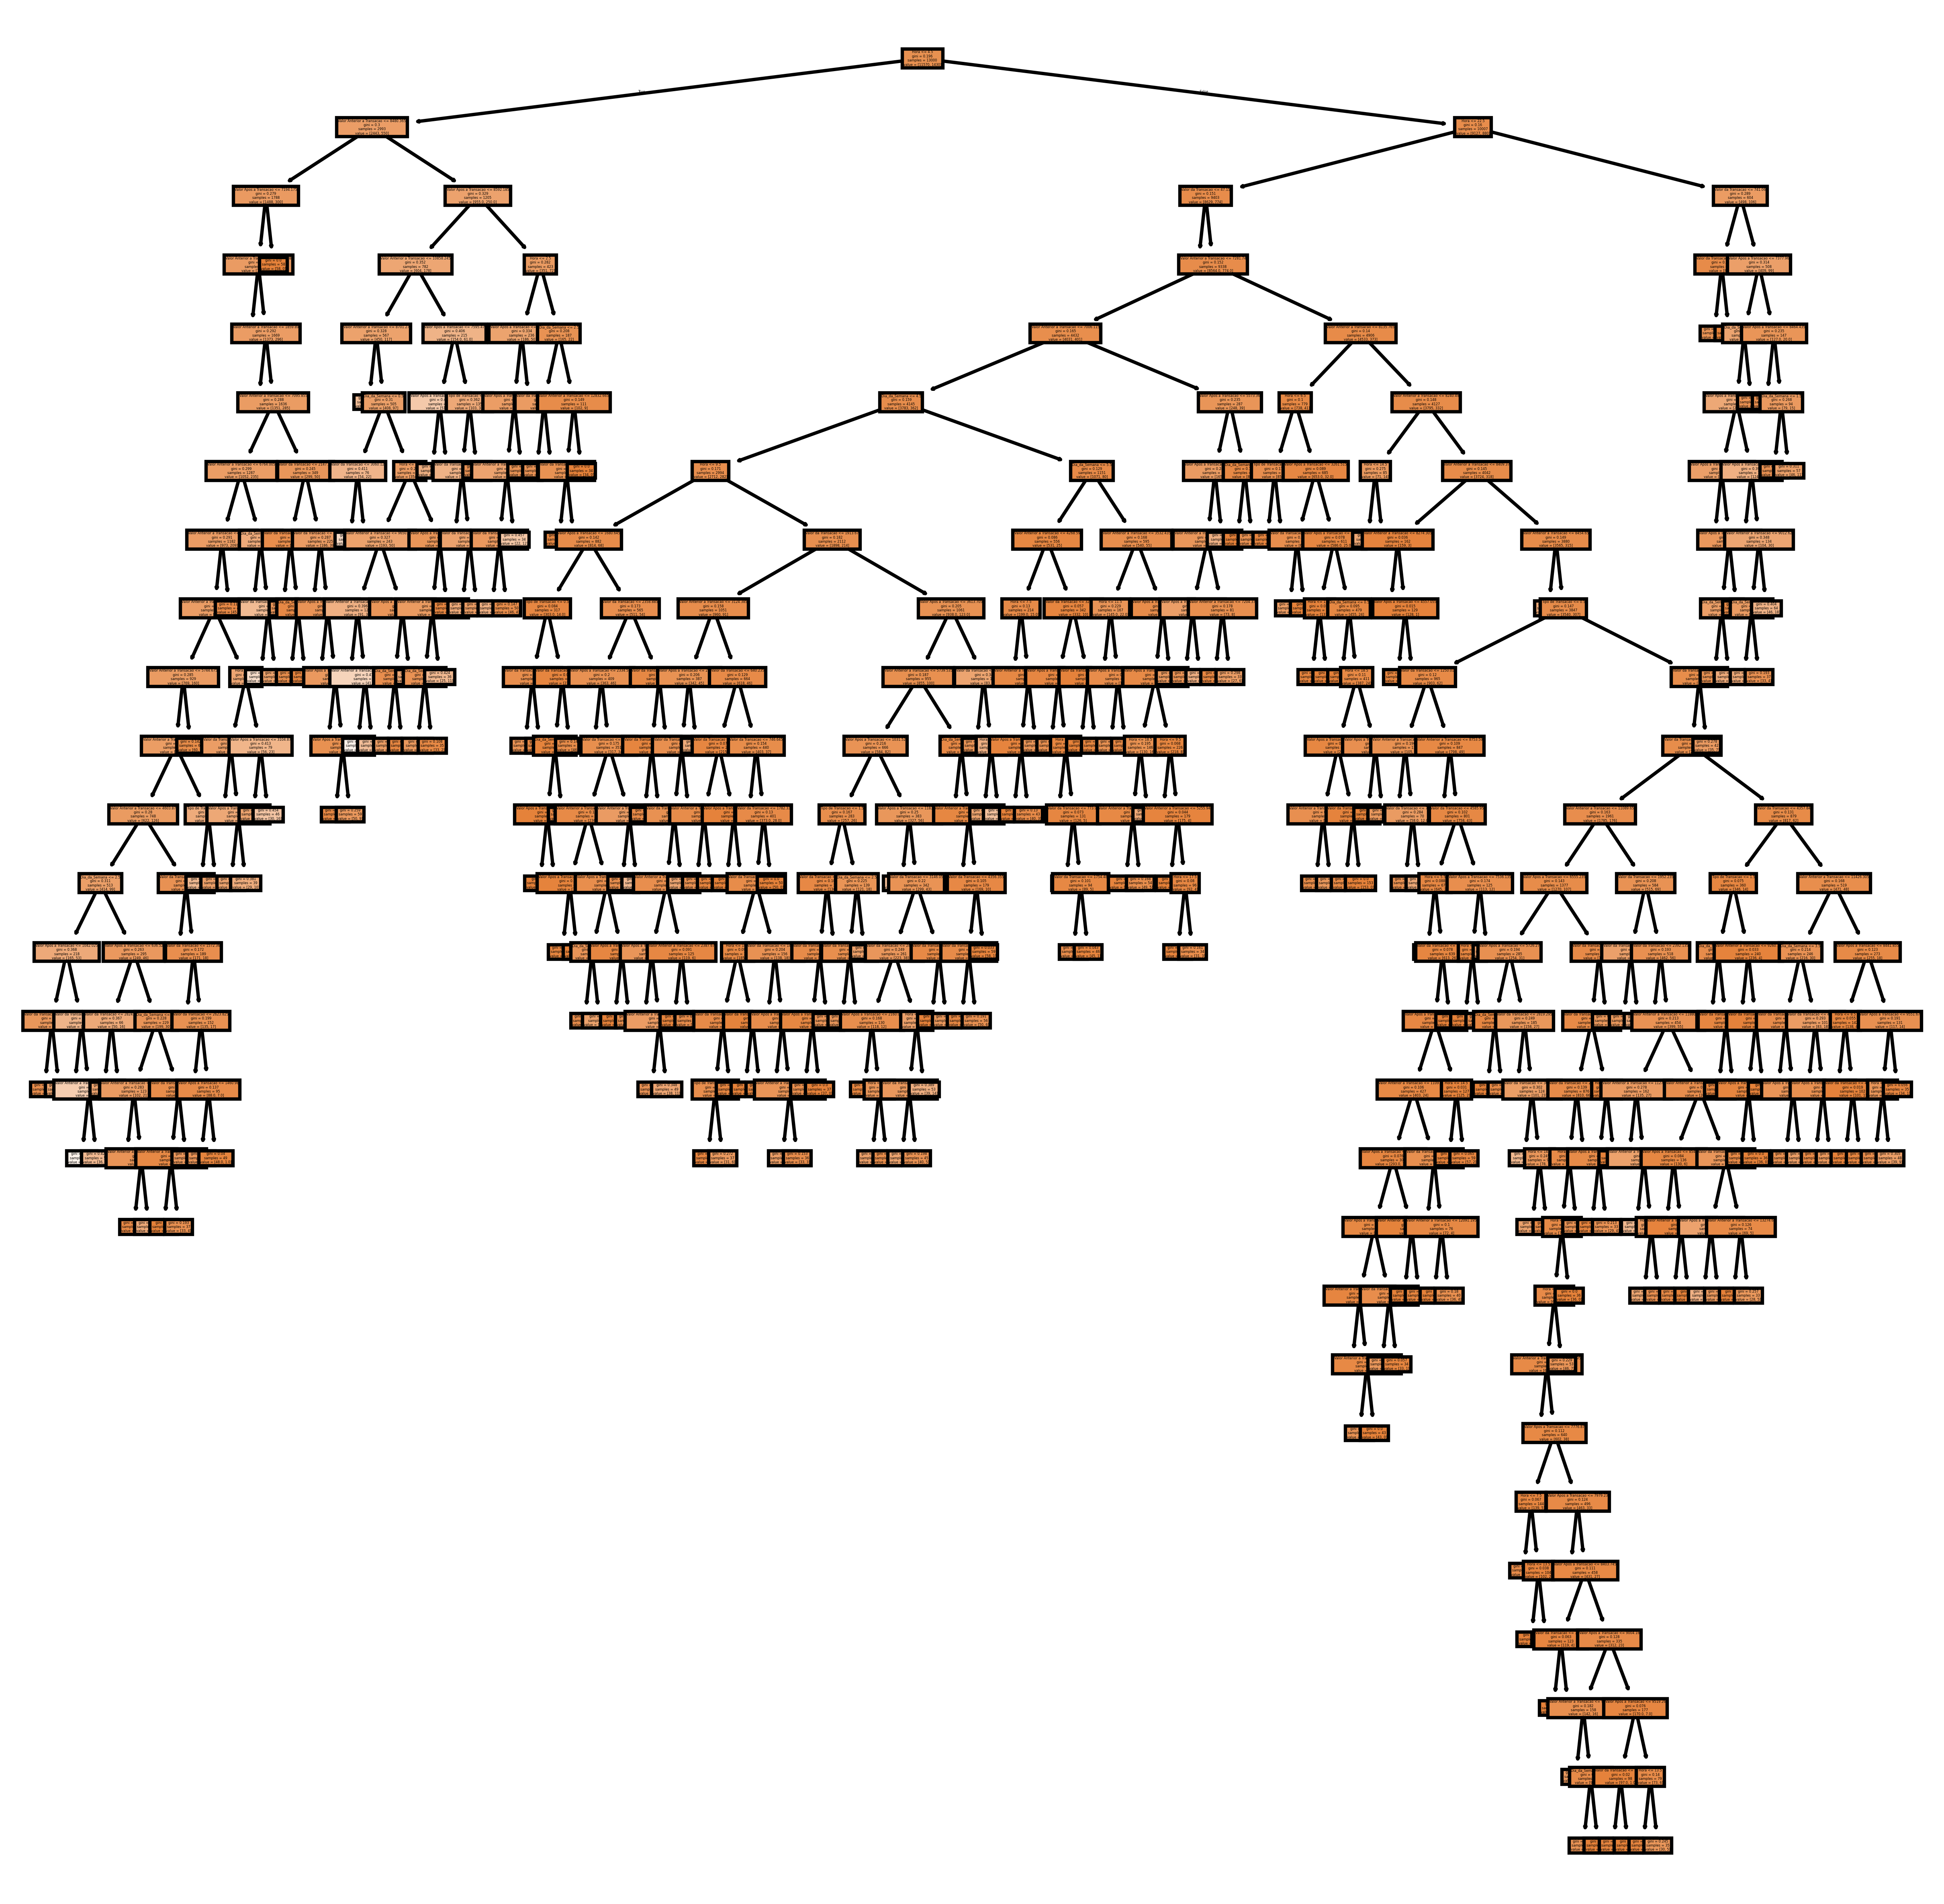

In [95]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=600)

plot_tree(
    clf_decision_tree,
    feature_names=X_train_tree.columns.to_numpy(),
    filled=True
)

### Salvar o modelo

In [96]:
import joblib

dt_model_tunado = Pipeline(
    steps=[
        ('preprocessing', preprocess),
        ('classifier',DecisionTreeClassifier(min_samples_leaf=estudo_decisiontreee.best_params['min_samples_leaf'],
                                            max_depth=estudo_decisiontreee.best_params['max_depth']))
    ]
)

dt_model_tunado.fit(X,y)

joblib.dump(dt_model_tunado, 'modelo_classificacao_decision_tree.pkl')

['modelo_classificacao_decision_tree.pkl']

### Entregar o modelo como App de predição Batch (por arquivo)

In [97]:
import gradio as gr

modelo = joblib.load("./modelo_classificacao_decision_tree.pkl")

def predict(arquivo):
    df_novas_transacoes = pd.read_csv(arquivo.name)
    y_pred = modelo.predict(df_novas_transacoes)
    df_classes = pd.DataFrame(y_pred, columns=['Classe'])
    df_predicoes = pd.concat([df_novas_transacoes, df_classes], axis=1)
    df_predicoes.to_csv('./predicoes.csv', index=False)

    return './predicoes.csv'

demo = gr.Interface(
    predict,
    gr.File(file_types=[".csv"]),
    "file"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
